In [1]:
#!/usr/bin/env python3
"""
PC1–neuron correlation analysis
Averages 50 repeats per image and tests r ≠ 0.
"""

import os, pickle
import numpy as np
import pandas as pd
from scipy.special import softmax
from skbio.stats.composition import clr
from sklearn.decomposition import PCA
from scipy.stats import pearsonr

# ---------------------------------------------------------------
# PATHS
# ---------------------------------------------------------------
VIT_PATH = '/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH = '/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy'

N_IMAGES = 118
REPEATS_PER_IMAGE = 50  # 5900 = 118 × 50

# ---------------------------------------------------------------
# LOAD DATA
# ---------------------------------------------------------------
dat = np.load(NEURAL_PATH)  # (n_neurons, 5900)
n_neurons, n_trials = dat.shape
print(f"Neural data shape: {n_neurons} neurons × {n_trials} trials")

# reshape to (neurons, images, repeats)
assert n_trials == N_IMAGES * REPEATS_PER_IMAGE, "Trial count must equal images × repeats"
dat_img_rep = dat.reshape(n_neurons, N_IMAGES, REPEATS_PER_IMAGE)

# average across repeats to get per-image mean firing
firing_mean = dat_img_rep.mean(axis=2)  # (n_neurons, 118)
print("Averaged to per-image firing rates:", firing_mean.shape)

# ---------------------------------------------------------------
# LOAD AND TRANSFORM ViT EMBEDDINGS
# ---------------------------------------------------------------
with open(VIT_PATH, 'rb') as f:
    vit_arr = pickle.load(f)['natural_scenes']
embeddings = np.asarray(vit_arr)
print("ViT embeddings shape:", embeddings.shape)

# softmax + CLR
from scipy.special import softmax
from skbio.stats.composition import clr
X = softmax(embeddings, axis=1)
X_clr = clr(X + 1e-12)

# PCA covering ≥90% variance
from sklearn.decomposition import PCA
pca_full = PCA().fit(X_clr)
cumvar = np.cumsum(pca_full.explained_variance_ratio_)
n_components = np.searchsorted(cumvar, 0.90) + 1
print(f"Selecting {n_components} PCs (covering {100*cumvar[n_components-1]:.2f}% variance)")

pca = PCA(n_components=n_components, random_state=0)
U = pca.fit_transform(X_clr)
pc1 = U[:, 1]  # (118,)

# ---------------------------------------------------------------
# CORRELATION ANALYSIS: PC1 vs firing per neuron
# ---------------------------------------------------------------
results = []
for j in range(n_neurons):
    y = firing_mean[j, :]
    if np.allclose(y, y[0]):  # constant neuron
        results.append((j, np.nan, np.nan))
        continue

    r, p = pearsonr(pc1, y)
    results.append((j, r, p))

df = pd.DataFrame(results, columns=["neuron_idx", "r_pc1", "pval_pc1"])
df.to_csv("corr_pc2.csv", index=False)
print("✅ Saved corr_pc1.csv")
print(df.head())

# Summary
n_sig = np.sum(df["pval_pc1"] < 0.05)
print(f"{n_sig}/{len(df)} neurons show significant correlation with PC1 (p<0.05)")


Neural data shape: 39209 neurons × 5900 trials
Averaged to per-image firing rates: (39209, 118)
ViT embeddings shape: (118, 1000)
Selecting 44 PCs (covering 90.31% variance)
✅ Saved corr_pc1.csv
   neuron_idx     r_pc1  pval_pc1
0           0 -0.043698  0.638462
1           1  0.008731  0.925238
2           2  0.035414  0.703409
3           3  0.086405  0.352192
4           4 -0.258255  0.004749
4409/39209 neurons show significant correlation with PC1 (p<0.05)


(array([7394., 4855., 4034., 3710., 3502., 3275., 3107., 3114., 3196.,
        3022.]),
 array([2.58387294e-06, 9.99988667e-02, 1.99995150e-01, 2.99991432e-01,
        3.99987715e-01, 4.99983998e-01, 5.99980281e-01, 6.99976564e-01,
        7.99972847e-01, 8.99969130e-01, 9.99965412e-01]),
 <BarContainer object of 10 artists>)

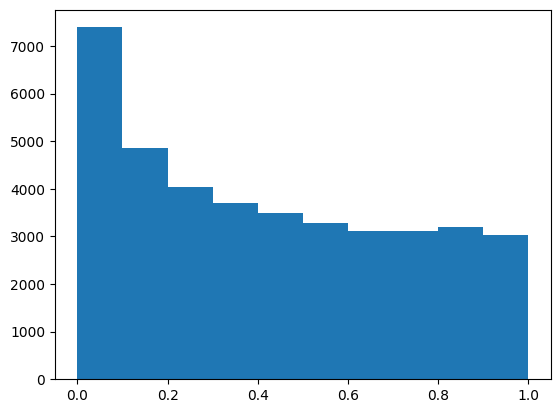

In [3]:
import matplotlib.pyplot as plt
plt.hist(df['pval_pc1'])

(array([5.8000e+01, 7.5000e+02, 4.1180e+03, 1.0213e+04, 1.2272e+04,
        8.0900e+03, 2.9280e+03, 6.7600e+02, 9.2000e+01, 1.2000e+01]),
 array([-0.41732473, -0.33403227, -0.25073981, -0.16744735, -0.08415488,
        -0.00086242,  0.08243004,  0.1657225 ,  0.24901496,  0.33230742,
         0.41559989]),
 <BarContainer object of 10 artists>)

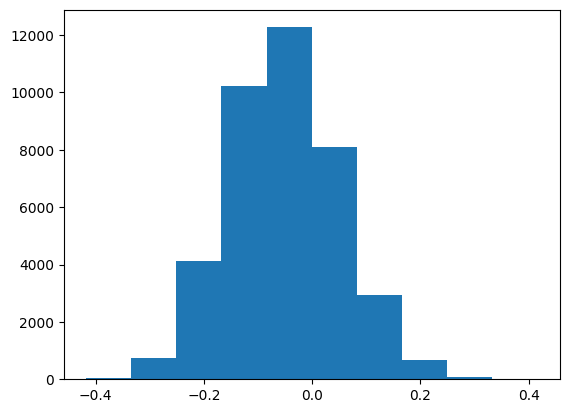

In [4]:
plt.hist(df['r_pc1'])